# TSP Belgium

In [1]:
!pip3 install networkx matplotlib numpy geopy

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
# Import required libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from geopy.distance import geodesic
import json

/Users/tijsvandenheuvel/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## helper functions

In [3]:
def getTestData(feature_collection, amount):
    subset_features = feature_collection['features'][:amount]
    feature_collection = {
        "type": "FeatureCollection",
        "features": subset_features
    }
    return feature_collection


# Function to calculate distances between points
def calculate_distance(coord1, coord2):
    return geodesic(coord1, coord2).kilometers

## load data

In [4]:
# Path to the GeoJSON file
#filename = 'villages.geojson'
#filename = 'villagesantwerp.geojson'
filename = 'gemeentes.geojson'

# Read the GeoJSON file
with open(filename, 'r') as file:
    feature_collection = json.load(file)

# get test data set
#feature_collection = getTestData(feature_collection,1000)

# Print the data to see what's inside
# print(json.dumps(feature_collection, indent=2))

# Print the number of features
num_features = len(feature_collection['features'])
print("Number of features:", num_features)

Number of features: 581


## create graph

In [5]:
# Create a graph
G = nx.Graph()

In [6]:
# Prepare nodes and add them to the graph
nodes = []
for feature in feature_collection['features']:
    name = feature['properties']['name']
    coords = tuple(feature['geometry']['coordinates'][::-1]) # Reverse to (lat, lon)
    nodes.append((name, coords))
    G.add_node(name, coordinates=coords)

581 nodes = 15s

1000 nodes = 44s

2000 nodes = 180s

3363 nodes = 8m29s

In [7]:
# Add edges with distances as weights
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        node1_name, node1_coords = nodes[i]
        node2_name, node2_coords = nodes[j]
        distance = calculate_distance(node1_coords, node2_coords)
        G.add_edge(node1_name, node2_name, weight=distance)

## solve TSP

In [8]:
# greedy algorithm

def getGreedyRoute(start_node):
    if start_node in G:
        tsp_route = nx.approximation.greedy_tsp(G, source=start_node, weight='weight')
        print("TSP Route starting from", start_node, ":", tsp_route)
    else:
        print(start_node, "not found in the data")
        
#tsp_route = getGreedyRoute("Hove")

581 nodes = 6.6s

In [9]:
# Christofides

#tsp_route = nx.approximation.traveling_salesman_problem(G, method='christofides', weight='weight')
tsp_route = nx.approximation.christofides(G, weight='weight')

In [10]:
# Starting node, if specific start is needed
start_node = 'Hove'  

# Check if the starting node exists in the graph
if start_node in G:
    
    # Rotate the tour to start at 'Hove'
    start_index = tsp_route.index(start_node)
    rotated_tsp_route = tsp_route[start_index:] + tsp_route[:start_index]
    tsp_route = rotated_tsp_route
    
    print("TSP Route using Christofides algorithm starting from", start_node, ":", tsp_route)
else:
    print(start_node, "not found in the data")

TSP Route using Christofides algorithm starting from Hove : ['Hove', 'Duffel', 'Sint-Katelijne-Waver', 'Bonheiden', 'Zemst', 'Mechelen', 'Tremelo', 'Begijnendijk', 'Rotselaar', 'Holsbeek', 'Herent', 'Leuven', 'Bertem', 'Oud-Heverlee', 'Bierbeek', 'Lubbeek', 'Boutersem', 'Beauvechain', 'La Bruyère', 'Hoegaarden', 'Tienen', 'Glabbeek', 'Linter', 'Zoutleeuw', 'Sint-Truiden', 'Nieuwerkerken', 'Geetbets', 'Kortenaken', 'Halen', 'Alken', 'Wellen', 'Kortessem', 'Borgloon', 'Heers', 'Oreye', 'Crisnée', 'Tongeren', 'Herstappe', 'Fexhe-le-Haut-Clocher', 'Awans', 'Juprelle', 'Ans', 'Grâce-Hollogne', 'Seraing', 'Flémalle', 'Engis', 'Saint-Georges-sur-Meuse', 'Verlaine', 'Villers-le-Bouillet', 'Donceel', 'Remicourt', 'Faimes', 'Waremme', 'Berloz', 'Geer', 'Gingelom', 'Landen', 'Lincent', 'Hélécine', 'Jodoigne', 'Incourt', 'Chaumont-Gistoux', 'Grez-Doiceau', 'Wavre', 'Rixensart', 'Ottignies-Louvain-la-Neuve', 'Court-Saint-Etienne', 'Mont-Saint-Guibert', 'Chastre', 'Walhain', 'Gembloux', 'Sombreffe',

## plot result

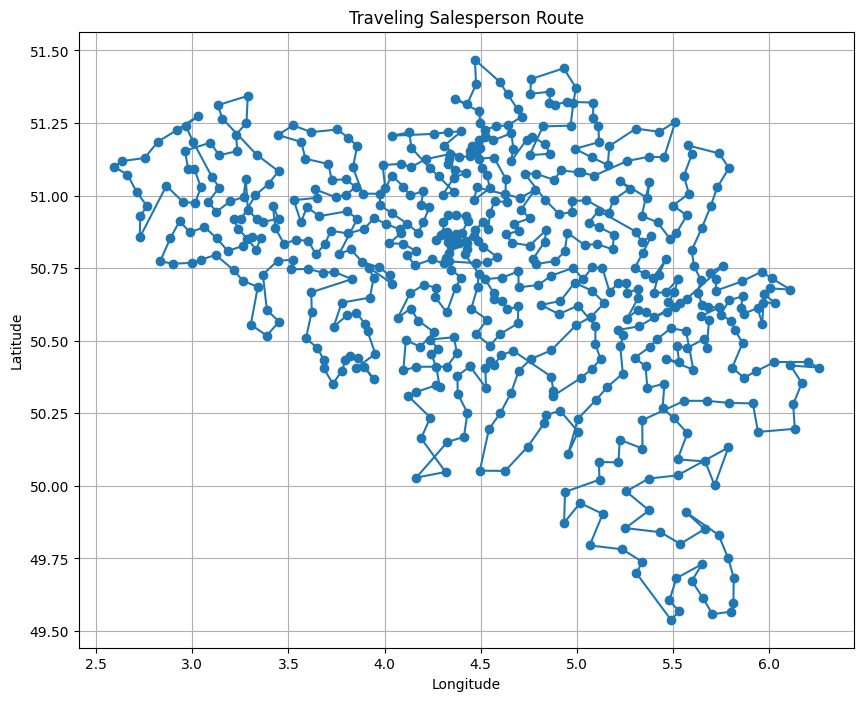

In [11]:
# Plotting the route
coords = {feature['properties']['name']: tuple(feature['geometry']['coordinates'][::-1]) for feature in feature_collection['features']}
route_coords = [coords[place] for place in tsp_route]

# Unpack coordinates for plotting
lats, lons = zip(*route_coords)

plt.figure(figsize=(10, 8))
plt.plot(lons, lats, 'o-')  # Plot points with lines between them

# for i, txt in enumerate(tsp_route):
#     plt.annotate(txt, (lons[i], lats[i]))

plt.title('Traveling Salesperson Route')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

## output routes

In [12]:
# Prepare to list the route with distances
route_with_distances = []

previous_place = None
total_distance = 0

# Iterate through the route
for place in tsp_route:
    if previous_place is not None:
        # Get coordinates
        coord1 = coords[previous_place]
        coord2 = coords[place]

        # Calculate distance
        distance = calculate_distance(coord1, coord2)
        total_distance += distance

        # Append to the route list
        route_with_distances.append({
            "from": previous_place,
            "to": place,
            "distance": f"{distance:.2f} km"
        })
    
    previous_place = place

# Optionally, to make the route circular
if len(tsp_route) > 1:
    first_place = tsp_route[0]
    last_place = tsp_route[-1]
    coord1 = coords[last_place]
    coord2 = coords[first_place]
    distance = calculate_distance(coord1, coord2)
    total_distance += distance
    route_with_distances.append({
        "from": last_place,
        "to": first_place,
        "distance": f"{distance:.2f} km"
    })

# Print the route with distances
for leg in route_with_distances:
    print(f"{leg['from']} -> {leg['to']} = {leg['distance']}")

# Print total distance
print(f"Total distance: {total_distance:.2f} km")


Hove -> Duffel = 6.22 km
Duffel -> Sint-Katelijne-Waver = 3.40 km
Sint-Katelijne-Waver -> Bonheiden = 5.09 km
Bonheiden -> Zemst = 7.42 km
Zemst -> Mechelen = 5.00 km
Mechelen -> Tremelo = 16.21 km
Tremelo -> Begijnendijk = 6.28 km
Begijnendijk -> Rotselaar = 9.12 km
Rotselaar -> Holsbeek = 4.72 km
Holsbeek -> Herent = 6.28 km
Herent -> Leuven = 3.31 km
Leuven -> Bertem = 5.18 km
Bertem -> Oud-Heverlee = 3.89 km
Oud-Heverlee -> Bierbeek = 6.53 km
Bierbeek -> Lubbeek = 8.57 km
Lubbeek -> Boutersem = 4.67 km
Boutersem -> Beauvechain = 7.83 km
Beauvechain -> La Bruyère = 2.16 km
La Bruyère -> Hoegaarden = 7.06 km
Hoegaarden -> Tienen = 5.12 km
Tienen -> Glabbeek = 7.29 km
Glabbeek -> Linter = 7.94 km
Linter -> Zoutleeuw = 4.40 km
Zoutleeuw -> Sint-Truiden = 6.16 km
Sint-Truiden -> Nieuwerkerken = 5.60 km
Nieuwerkerken -> Geetbets = 6.32 km
Geetbets -> Kortenaken = 4.02 km
Kortenaken -> Halen = 5.87 km
Halen -> Alken = 15.83 km
Alken -> Wellen = 4.30 km
Wellen -> Kortessem = 4.05 km
Kortes